In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

import sys
sys.path.append("./modules/") # for d3plus2

sys.path.append("./../Hidalgo_Haussmann") # for HH tools
from HH_tools import *

import d3plus2 as d3plus

import numpy as np

In [47]:
data_path = './../../../../../media/miglesia/Elements/Matias_Iglesias_Backup/miglesia/Documents/compute-corr-structures/data/'

X = pd.read_csv(data_path + 'processed/BRA_MIR_WD0_E2_I2_main_table.csv', index_col=0)
X = X[[col for col in X.columns if 'Membros das forcas armadas, policiais e bombeiros militares' not in col]]
X.columns.name = 'industry_code'

# X = pd.read_csv(data_path + 'processed/CHI_COM_W4_O4_E2_I2_main_table.csv', index_col=0)
# X.columns.name = 'industry_code'


In [48]:
# sum([1 for l in list(X.columns.values) if 'Wages' in l])
X.shape

(558, 152)

### Population and land uses

In [49]:
df_CHI = pd.read_csv('./data/pop_dist_comuna.csv')
df_CHI = df_CHI.rename(columns = {'comuna_id': 'CHI ID COM'}).set_index('CHI ID COM')[['poblacion', 'area_km2']]


In [50]:
X = pd.concat([df_CHI.loc[X.index], X], axis = 1, sort = True)#.dropna()

KeyError: u"None of [Index([u'1ac0000', u'1ac0001', u'1ac0100', u'1ac0101', u'1ac0102', u'1am0000',\n       u'1am0001', u'1am0002', u'1am0003', u'1am0004',\n       ...\n       u'5sc0204', u'5sc0300', u'5sc0301', u'5sc0400', u'5sc0401', u'5sc0402',\n       u'5sc0500', u'5sc0501', u'5sc0502', u'5sc0503'],\n      dtype='object', name=u'BRA ID MIR', length=558)] are in the [index]"

### Area and industry titles

In [51]:
path = './../growth-lab-diversity/data/sources/'
agglevel_titles = pd.read_csv(path+'agglevel_titles.csv')
area_titles = pd.read_csv(path+'area_titles.csv')

industry_titles = pd.DataFrame(np.array([X.columns.values, X.columns.values]).T, 
                               columns = ['industry_code', 'industry_title'])

In [52]:
cor_mat = log10(X).corr(min_periods = 20)
cov_mat = log10(X).cov(min_periods = 20)

In [53]:
def demean(Z):
    Z = Z.fillna(0)
    means = Z.mean()
    return (Z.T - means).T - means + means.mean()

def stand(Z):
    Z = Z.fillna(0)
    std = Z.std()
    return Z.T.div(std).T.div(std)

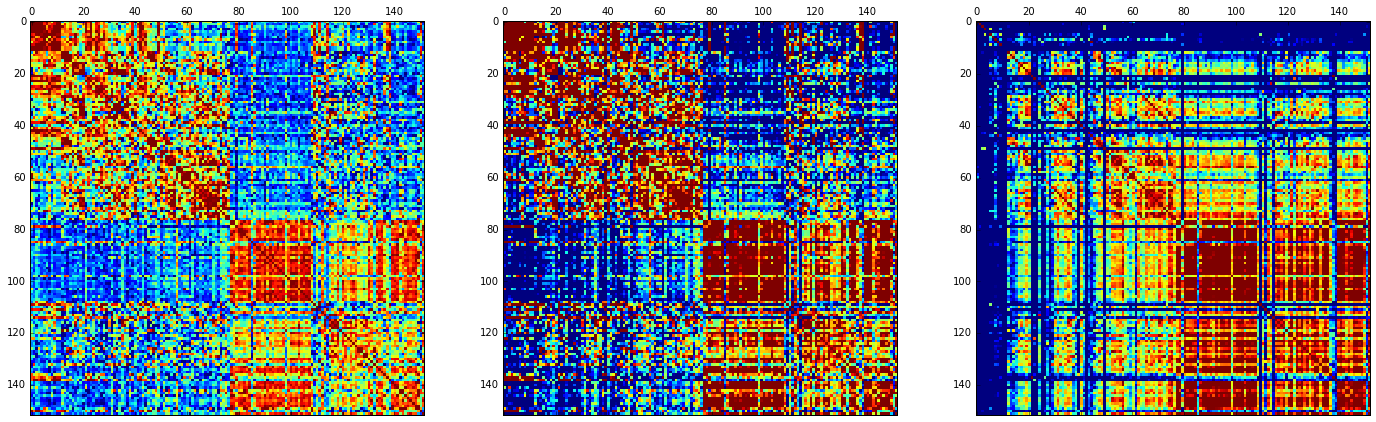

In [54]:
# mat = demean(cor_mat.fillna(0))
# mat = cor_mat
fig, axs = plt.subplots(1, 3, figsize = (24, 8))

axs[0].matshow(demean(stand(demean(cor_mat))), vmin = -10, vmax = 10)
axs[1].matshow(demean(cor_mat), vmin = -.1, vmax = .1)
axs[2].matshow(cor_mat.fillna(0), vmin = .2, vmax = .7)

# plt.hist(stand(demean(cor_mat)).std(), 30)
# plt.show()

In [55]:
# Try spectral clustering. Works when matrix is demeaned
from sklearn.cluster import SpectralClustering
X_ = demean(cor_mat).values
clustering = SpectralClustering(n_clusters=20,
        assign_labels="discretize",
        random_state=0).fit(X_)

pd.options.display.max_rows = 500
clust_result = pd.DataFrame(clustering.labels_, index = X.columns, columns = ['cluster'])
clust_result.index.name = 'industry_code'
clust_result = pd.concat([clust_result, industry_titles.set_index('industry_code')], axis = 1, sort = False).dropna().sort_values(by = ['cluster', 'industry_title'])

In [56]:
edges = pd.DataFrame(demean(cor_mat).stack(), columns = ['dem_corr'])
# > demean(cor_mat).values, 90
# edges.loc[]
edges_s = edges.loc[edges.dem_corr > edges.dem_corr.quantile(.80)]
edges_s.index.names = ['industry_code_x', 'industry_code_y']

edges_s.reset_index().columns
edges_s = edges_s.reset_index().merge(
    industry_titles, left_on = 'industry_code_x', right_on = 'industry_code').merge(
    industry_titles, left_on = 'industry_code_y', right_on = 'industry_code').T.drop_duplicates().T
edges_s['dem_corr'] = edges_s['dem_corr'].astype(float)

In [57]:
# #Load modules
# from numpy.random import choice 
# from numpy import where, power

In [58]:
import matplotlib.colors as mcolors

# nodes = industry_titles

scale = .005
nodes_size = scale*pd.DataFrame(np.sqrt(X.sum()), columns=['sqrt_size'])
nodes = pd.concat([nodes_size, clust_result], axis = 1, sort = False)

norm = mcolors.Normalize(vmin=0, vmax=10, clip=True)
mapper = plt.cm.ScalarMappable(norm=norm, cmap=plt.cm.jet)

nodes['color'] = nodes['cluster'].apply(lambda x: mcolors.rgb2hex(mapper.to_rgba(x)))

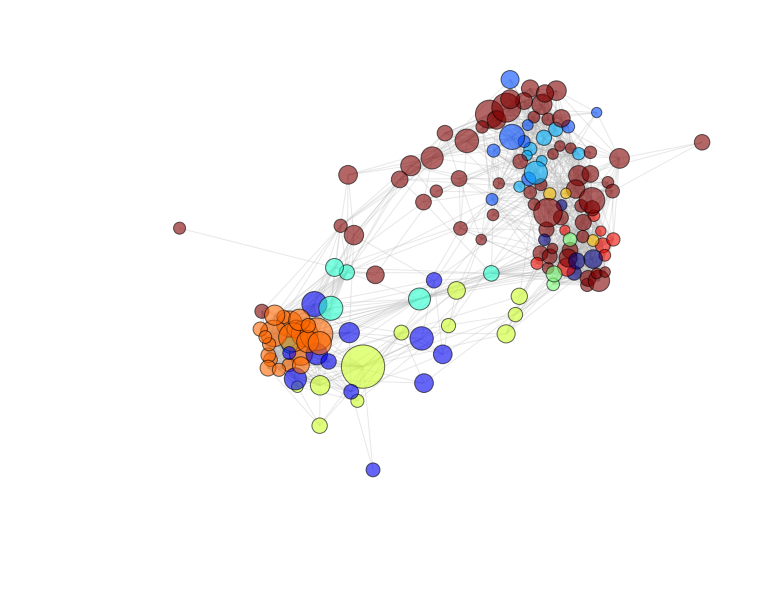

In [59]:
max_d = 30
weight_column = 'dem_corr' #'weight_'+geo

        ### Max degree = max_d. Parameter used to trim the network.
df1 = edges_s.groupby('industry_code_x').apply(lambda x: x.nlargest(max_d, weight_column)).reset_index(drop = True)
df2 = edges_s.groupby('industry_code_y').apply(lambda x: x.nlargest(max_d, weight_column)).reset_index(drop = True)
edges_max_d = df1.merge(df2, on = ['industry_code_x', 'industry_code_y', weight_column]).reset_index(drop = True)

###

# Hard threshold and max degree backboning

G = nx.from_pandas_edgelist(edges_max_d, 'industry_code_x', 'industry_code_y', weight_column)


plt.figure(figsize = (10, 8))

G = max(nx.connected_component_subgraphs(G), key=len)
nodes_s = nodes.loc[G.nodes.keys()]
pos = nx.spring_layout(G, k=.3)

nx.draw(G, pos, node_size = nodes_s.sqrt_size.values, alpha=.6, node_color= list(nodes_s.color.values), edgelist = [])
nx.draw_networkx_edges(G, pos, edge_color='.7', alpha=.3)
# plt.title('max_d = '+str(max_d))
#     plt.savefig('./Figures/5_max_deg/'+col_name+'_plot1.png')
#             plt.show()

plt.show()

### Draw in d3plus

In [60]:
# nodes
pos_df = pd.DataFrame(pos, index = ['x', 'y']).T
nodes_wpos = pd.concat([nodes_s, pos_df], axis = 1, sort = False)

In [61]:
nodes_ = nodes_wpos.reset_index()[['index','x', 'y', 'industry_title', 'color']].dropna(subset = ['x']).rename({'index': 'id'}, axis = 1)
nodes_['id'] = nodes_['id'].astype(str).str.zfill(4)
nodes_[['x', 'y']] = 500 * nodes_[['x', 'y']]


In [62]:
# nodes_['id'].values#.head()

In [63]:
# nodes_.sort_values(by = 'id')#.loc[nodes_.id == 'Desert']

In [64]:
import sys
sys.path.append("./../Hidalgo_Haussmann") # for HH tools
import pandas as pd
from HH_tools import robust_proximity, year_to_tp, RCA

In [65]:
nodes_['presence'] = True

edges_max_d['edge_tuple'] = list(zip(edges_max_d.industry_code_x, edges_max_d.industry_code_y))
edges_max_d['edge_tuple_rev'] = list(zip(edges_max_d.industry_code_y, edges_max_d.industry_code_x))
edges_max_d_triangles = edges_max_d.loc[edges_max_d.edge_tuple.isin(G.edges()) | edges_max_d.edge_tuple_rev.isin(G.edges())]

links = edges_max_d_triangles.reset_index().rename({weight_column: 'strength'},axis = 1)
links['target'] = links['industry_code_y'].astype(str).str.zfill(4)
links['source'] = links['industry_code_x'].astype(str).str.zfill(4)

# links = nc_backbone.reset_index().rename({'score': 'strength'},axis = 1)
# links['target'] = links['trg'].astype(str).str.zfill(4)
# links['source'] = links['src'].astype(str).str.zfill(4)

network = '{"nodes": '+nodes_.to_json(orient= 'records')+', "edges": '+links[['index', 'source', 'target']].to_json(orient= 'records')+'}\n'
# network

In [66]:
## Conditional coloring

# Manufacturing (light_blue) and services (yellow)
nodes_['color_mfg_srv'] = 'D3D3D3' #Gray bckg

conditions = [
    (nodes_['industry_title'].str.lower().str.contains('poblacion')) + (nodes_['industry_title'].str.lower().str.contains('area')),
    (nodes_['industry_title'].str.lower().str.contains('export')),
#     (nodes_['industry_title'].str.lower().str.contains('output')),
    (nodes_['industry_title'].str.lower().str.contains('wages')),# or (nodes_['industry_title'].str.lower().str.contains('mfg')),
    (nodes_['industry_title'].str.lower().str.contains('import'))]

choices = ['#000000','#000080', '#ffc400', '#00b0ff']

nodes_['color_mfg_srv'] = np.select(conditions, choices, default='#D3D3D3')


In [67]:
edges_max_d_triangles.to_csv('edges_max_d_triangles.csv', index = False)

In [68]:
ps = d3plus.ProductSpace(
id="name",
name="industry_title",
color="color_mfg_srv",
graph_data=network,
presence="presence",
edge_property="edges",
network_id="id")
ps.draw(nodes_)

<IPython.core.display.Javascript object>

In [69]:
ps = d3plus.ProductSpace(
id="name",
name="industry_title",
color="color",
graph_data=network,
presence="presence",
edge_property="edges",
network_id="id")
ps.draw(nodes_)

<IPython.core.display.Javascript object>

### Activities by cluster

In [70]:
pd.set_option('display.max_colwidth', -1)
summary = nodes.groupby('cluster').agg({'industry_title': 'first', 'color':[ 'first', 'count']})
summary.columns = ['color', 'node_count','example']
summary.sort_index()#.sort_values(by = 'node_count')

,color,node_count,example
cluster,,,
0,#000080,5,Exports of '10 - Cereals'
1,#0000f1,12,Wages of ''Alimentacao' in 'All occupations''
2,#004cff,9,"Exports of '48 - Paper and paperboard; articles of paper pulp, of paper or paperboard'"
3,#00b0ff,8,"Exports of '32 - Tanning or dyeing extracts; tannins and their derivatives; dyes, pigments and other colouring matter; paints, varnishes; putty, other mastics; inks'"
4,#29ffce,6,"Wages of ''Agricultura, pecuaria e servicos relacionados' in 'All occupations''"
5,#7dff7a,3,Wages of ''Atividades de apoio a extracao de minerais' in 'All occupations''
6,#ceff29,11,"Wages of ''Administracao publica, defesa e seguridade social' in 'All occupations''"
7,#ffc400,3,Exports of '64 - Footwear; gaiters and the like; parts of such articles'
8,#ff6800,22,"Wages of ''Atividades auxiliares dos servicos financeiros, seguros, previdencia complementar e planos de saude' in 'All occupations''"


In [71]:
# nodes_.loc[nodes_['color'].isin(['#f10800', '#ff6800', '#ceff29', '#29ffce'])].sort_values(by = ['color','industry_title'])
nodes_.sort_values(by = ['color','industry_title'])

,id,x,y,industry_title,color,presence,color_mfg_srv
22,Exports of '10 - Cereals',184.943758,-66.758720,Exports of '10 - Cereals',#000080,True,#000080
115,"Exports of '12 - Oil seeds and oleaginous fruits; miscellaneous grains, seeds and fruit, industrial or medicinal plants; straw and fodder'",189.468480,-40.750412,"Exports of '12 - Oil seeds and oleaginous fruits; miscellaneous grains, seeds and fruit, industrial or medicinal plants; straw and fodder'",#000080,True,#000080
129,"Exports of '22 - Beverages, spirits and vinegar'",133.348356,5.189078,"Exports of '22 - Beverages, spirits and vinegar'",#000080,True,#000080
105,"Imports of '22 - Beverages, spirits and vinegar'",163.231116,80.615059,"Imports of '22 - Beverages, spirits and vinegar'",#000080,True,#00b0ff
74,Imports of '31 - Fertilizers',218.004577,-36.654470,Imports of '31 - Fertilizers',#000080,True,#00b0ff
20,Wages of ''Alimentacao' in 'All occupations'',-261.841586,-242.696364,Wages of ''Alimentacao' in 'All occupations'',#0000f1,True,#ffc400
133,Wages of ''Alojamento' in 'All occupations'',-241.296860,-258.924865,Wages of ''Alojamento' in 'All occupations'',#0000f1,True,#ffc400
148,Wages of ''Alugueis nao-imobiliarios e gestao de ativos intangiveis nao-financeiros' in 'All occupations'',-202.044943,-324.505745,Wages of ''Alugueis nao-imobiliarios e gestao de ativos intangiveis nao-financeiros' in 'All occupations'',#0000f1,True,#ffc400
147,Wages of ''Armazenamento e atividades auxiliares dos transportes' in 'All occupations'',-75.639383,-305.817821,Wages of ''Armazenamento e atividades auxiliares dos transportes' in 'All occupations'',#0000f1,True,#ffc400
109,"Wages of ''Coleta, tratamento e disposicao de residuos; recuperacao de materiais' in 'All occupations''",-164.179416,-494.062313,"Wages of ''Coleta, tratamento e disposicao de residuos; recuperacao de materiais' in 'All occupations''",#0000f1,True,#ffc400


### Keywords by cluster

In [72]:
# Cluster 7, #ffc400 are 76 nodes that follow neither population nor land resources. Then what is it all about?
from collections import Counter
from nltk.corpus import stopwords 
stop_words = set(stopwords.words('english')) 

from IPython.display import display, HTML
import colorlover as cl    
    
for clsr in range(10):
    try:
        
        text = nodes.loc[nodes.cluster == clsr]['industry_title']

        r1 = text.str.lower().str.split().values
        r1 = [item for sublist in r1 for item in sublist]

        r1_f = [w.replace(',', '').replace("'", "").replace('mfg.', 'manufacturing') for w in r1 if not w in stop_words] 

        print(summary.loc[clsr])
        color = summary.loc[clsr]['color']
        display(HTML(cl.to_html( [tuple(int(color.lstrip('#')[i:i+2], 16) for i in (0, 2 ,4))] )))
        print(Counter(r1_f).most_common()[:12])
        print('\n')
    except:
        pass

color         #000080                  
node_count    5                        
example       Exports of '10 - Cereals'
Name: 0, dtype: object


[('-', 5), ('exports', 3), ('imports', 2), ('spirits', 2), ('22', 2), ('vinegar', 2), ('beverages', 2), ('seeds', 2), ('industrial', 1), ('cereals', 1), ('straw', 1), ('plants;', 1)]


color         #0000f1                                      
node_count    12                                           
example       Wages of ''Alimentacao' in 'All occupations''
Name: 1, dtype: object


[('all', 12), ('occupations', 12), ('wages', 12), ('e', 9), ('de', 6), ('atividades', 3), ('servicos', 3), ('tecnicas', 2), ('para', 2), ('equipamentos', 1), ('alojamento', 1), ('disposicao', 1)]


color         #004cff                                                                               
node_count    9                                                                                     
example       Exports of '48 - Paper and paperboard; articles of paper pulp, of paper or paperboard'
Name: 2, dtype: object


[('-', 8), ('paper', 6), ('imports', 5), ('articles', 5), ('thereof', 4), ('exports', 3), ('paperboard;', 2), ('aluminium', 2), ('48', 2), ('illuminated', 2), ('76', 2), ('paperboard', 2)]


color         #00b0ff                                                                                                                                                              
node_count    8                                                                                                                                                                    
example       Exports of '32 - Tanning or dyeing extracts; tannins and their derivatives; dyes, pigments and other colouring matter; paints, varnishes; putty, other mastics; inks'
Name: 3, dtype: object


[('-', 8), ('exports', 7), ('thereof', 3), ('tannins', 2), ('tanning', 2), ('matter;', 2), ('pigments', 2), ('parts', 2), ('extracts;', 2), ('mastics;', 2), ('derivatives;', 2), ('inks', 2)]


color         #29ffce                                                                        
node_count    6                                                                              
example       Wages of ''Agricultura, pecuaria e servicos relacionados' in 'All occupations''
Name: 4, dtype: object


[('de', 7), ('all', 6), ('occupations', 6), ('wages', 6), ('e', 5), ('fabricacao', 3), ('artigos', 2), ('acessorios', 1), ('complementar', 1), ('pecuaria', 1), ('agricultura', 1), ('alimenticios', 1)]


color         #7dff7a                                                                     
node_count    3                                                                           
example       Wages of ''Atividades de apoio a extracao de minerais' in 'All occupations''
Name: 5, dtype: object


[('all', 3), ('occupations', 3), ('de', 3), ('wages', 3), ('extracao', 2), ('aquaviario', 1), ('apoio', 1), ('e', 1), ('petroleo', 1), ('gas', 1), ('minerais', 1), ('atividades', 1)]


color         #ceff29                                                                            
node_count    11                                                                                 
example       Wages of ''Administracao publica, defesa e seguridade social' in 'All occupations''
Name: 6, dtype: object


[('all', 11), ('occupations', 11), ('wages', 11), ('de', 10), ('e', 8), ('atividades', 2), ('servicos', 2), ('social', 2), ('em', 1), ('eletricidade', 1), ('seguridade', 1), ('alojamento', 1)]


color         #ffc400                                                                 
node_count    3                                                                       
example       Exports of '64 - Footwear; gaiters and the like; parts of such articles'
Name: 7, dtype: object


[('articles', 3), ('-', 3), ('exports', 2), ('footwear;', 2), ('gaiters', 2), ('parts', 2), ('64', 2), ('like;', 2), ('asbestos', 1), ('imports', 1), ('plaster', 1), ('stone', 1)]


color         #ff6800                                                                                                                              
node_count    22                                                                                                                                   
example       Wages of ''Atividades auxiliares dos servicos financeiros, seguros, previdencia complementar e planos de saude' in 'All occupations''
Name: 8, dtype: object


[('all', 22), ('occupations', 22), ('wages', 22), ('de', 21), ('e', 17), ('atividades', 11), ('servicos', 6), ('comercio', 3), ('automotores', 2), ('edicao', 2), ('impressao', 2), ('pessoais', 2)]


color         #f10800                                            
node_count    8                                                  
example       Exports of '21 - Miscellaneous edible preparations'
Name: 9, dtype: object


[('-', 5), ('exports', 4), ('de', 4), ('all', 3), ('occupations', 3), ('wages', 3), ('precious', 3), ('metals', 2), ('wood', 2), ('articles', 2), ('cereals', 1), ('imports', 1)]




### Map distribution from different clusters

In [ ]:
# nodes
import geopandas as gpd

counties = gpd.read_file('./data/cb_2017_us_county_500k/cb_2017_us_county_500k.shp')
counties['area_fips'] = counties.STATEFP + counties.COUNTYFP


In [ ]:
### A little trick. Distribution of neigbors of node 'Naics 5417 Scientific Research and Development Services'
# nodes_.loc[nodes_.id == '5417']
ego_node = 'Desert' #'Cropland' #'POPESTIMATE2010'# '5417'

neigh = edges_max_d_triangles.loc[(edges_max_d_triangles.industry_code_x == ego_node) |
                                  (edges_max_d_triangles.industry_code_y == ego_node)]
neigh_ids = list(set(neigh['industry_code_x'].unique()).union(set(neigh['industry_code_y'].unique())))
# nodes_.loc[nodes_.id.isin(neigh_ids)]['id'].values

node_ids = neigh_ids

In [ ]:
# gdf.loc[gdf.industry_code == naics]['annual_avg_estabs']
# df_neigh
# df_neigh.groupby('industry_code').mean().sort_values(by = 'annual_avg_estabs').tail(5).index

In [ ]:
from PIL import Image, ImageDraw, ImageFont


In [ ]:
# Choose indus to process...
n = 5
merged = df_agglv_yravg.groupby(level = 1)['annual_avg_estabs'].sum().reset_index().merge(nodes_, left_on = 'industry_code', right_on = 'id')
display_indus = merged.loc[merged.groupby('color')['annual_avg_estabs'].nlargest(n).index.get_level_values(1)]

#Filter original data to have these neighboring industries
df_agglv = df.loc[df.agglvl_code == 76]

df_agglv_yravg = df_agglv.groupby(['area_fips', 'industry_code']).mean().drop(['agglvl_code','year'], axis = 1)
# df_indu_prc_area = df_agglv_yravg.groupby(level=0).apply(lambda x: 100 * x / x.sum())
df_indu_prc_area = log10(df_agglv_yravg)

df_ = df_indu_prc_area.reset_index()

i = 0
open('./Figures/7_compo_USA_nw/labels.txt', 'w').close()
for color in nodes_.color.unique():
  
    cluster_ids = nodes_.loc[nodes_.color == color]['id']
    node_ids = cluster_ids.values
    
    df_neigh = df_.loc[df_.industry_code.isin(nodes_.loc[nodes_.id.isin(node_ids)]['id'].values)]
    df_neigh = df_neigh.set_index('area_fips')
    
    counties_ = counties.set_index('area_fips').reindex(df_neigh.index)[['geometry']]
    gdf = gpd.GeoDataFrame(pd.concat([df_neigh, counties_], axis = 1, sort = True).dropna())

    # Sample of cluster color
    rgb_tuple = tuple(int(color.lstrip('#')[i:i+2], 16) for i in (0, 2 ,4))
    im = Image.new('RGBA', (20, 20), rgb_tuple)
    im.save('./Figures/7_compo_USA_nw/cp_'+str(i)+'.png')

    for naics in display_indus['industry_code'].values:
        if( gdf.loc[gdf.industry_code == naics]['annual_avg_estabs'].mean() > .2 ):#& (i <=5): # Dismiss small indus
            node_info = nodes_.loc[nodes_.id == naics]
            
            # send node labels to test (they will then go to svg of figure)
            with open('./Figures/7_compo_USA_nw/labels.txt', 'a') as f:
                f.write(node_info['industry_title'].values[0]+'\n')
            display(node_info)
            display(HTML(cl.to_html( [rgb_tuple] )))

            ax = gdf.loc[gdf.industry_code == naics].plot(
                column='annual_avg_estabs', cmap=plt.cm.gist_yarg, vmin = 0, vmax = 1.5, linewidth = 0, figsize = (10, 6.5))
            ax.set_xlim(-130, -60)
            ax.set_ylim(22, 50)#, figsize=figsize, scheme='equal_interval', k=colors, legend=True)
#             plt.axis('off')
            ax.get_xaxis().set_ticks([])
            ax.get_yaxis().set_ticks([])
            plt.text(-128, 23.5, 'NAICS '+str(node_info['id'].values[0]), fontsize=30) # position in lat lon
            plt.savefig('./Figures/7_compo_USA_nw/'+str(node_info['id'].values[0])+'.png', bbox_inches = 'tight')
            plt.show()
    i+=1

In [ ]:
# TXT2InkscapeXMLv3.py

# A simple Python 3 script to look through a list of text and
# turn each line into an xml entry for use in Inkscape.
# in this script we will slightly spread the text to allow
# the user a better chance of retaining the order of their
# initial text.  Inkscape can be used to spread it out
# using the Align and Distribute Tool.


ofilenm = './Figures/7_compo_USA_nw/figure.svg'#str(input("What is the filename you wish for output?"))
outfile = open(ofilenm,"w")

ListFlm = './Figures/7_compo_USA_nw/labels.txt'#str(input("What is the name and location of the TXT file to work with?"))

Loctn = 75 #Vertical position to start text insertion
SpacingV = 25  #The vertical spacing between lines.

# The block that follows is the Inkscape standard header.
TextBlockA = '''<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!-- Created with Inkscape (http://www.inkscape.org/) -->

<svg
   xmlns:dc="http://purl.org/dc/elements/1.1/"
   xmlns:cc="http://creativecommons.org/ns#"
   xmlns:rdf="http://www.w3.org/1999/02/22-rdf-syntax-ns#"
   xmlns:svg="http://www.w3.org/2000/svg"
   xmlns="http://www.w3.org/2000/svg"
   xmlns:sodipodi="http://sodipodi.sourceforge.net/DTD/sodipodi-0.dtd"
   xmlns:inkscape="http://www.inkscape.org/namespaces/inkscape"
   width="744.09448819"
   height="1052.3622047"
   id="svg2"
   version="1.1"
   inkscape:version="0.48.4 r9939"
   sodipodi:docname="New document 1">
  <defs
     id="defs4" />
  <sodipodi:namedview
     id="base"
     pagecolor="#ffffff"
     bordercolor="#666666"
     borderopacity="1.0"
     inkscape:pageopacity="0.0"
     inkscape:pageshadow="2"
     inkscape:zoom="0.35"
     inkscape:cx="375"
     inkscape:cy="520"
     inkscape:document-units="px"
     inkscape:current-layer="layer1"
     showgrid="false"
     inkscape:window-width="1280"
     inkscape:window-height="742"
     inkscape:window-x="-2"
     inkscape:window-y="-3"
     inkscape:window-maximized="1" />
  <metadata
     id="metadata7">
    <rdf:RDF>
      <cc:Work
         rdf:about="">
        <dc:format>image/svg+xml</dc:format>
        <dc:type
           rdf:resource="http://purl.org/dc/dcmitype/StillImage" />
        <dc:title></dc:title>
      </cc:Work>
    </rdf:RDF>
  </metadata>
  <g
     inkscape:label="Layer 1"
     inkscape:groupmode="layer"
     id="layer1">'''

TextBlockB = '''<text\n
        xml:space="preserve"
        style="font-size:20px;font-style:normal;font-weight:normal;line-height:125%;letter-spacing:0px;word-spacing:0px;fill:#000000;fill-opacity:1;stroke:none;font-family:Sans"
        x="93.910118"
        y="'''
TextBlockC = '''id="text2989"
        sodipodi:linespacing="150%"><tspan
            sodipodi:role="line"
            id="tspan2991"
            x="93.910118"
            y="'''

outfile.write(TextBlockA)

# The section that follows is to build the SVG text elements
f = open(ListFlm,"r")
for line in f:
    TXTLine = line.strip()
    Loctn = Loctn + SpacingV
    InsertStrng1 = str(Loctn)+'"\n'
    InsertStrng2= str(Loctn)+'">'+TXTLine+'</tspan></text>\n'
    outfile.write(TextBlockB)
    outfile.write(InsertStrng1)
    outfile.write(TextBlockC)
    outfile.write(InsertStrng2)

# The next section is the close off for the SVG xml.

outfile.write('  </g>\n')
outfile.write('</svg>\n')

outfile.close()
print("Done")

In [ ]:
# Choose indus to process...
n = 5
merged = df_agglv_yravg.groupby(level = 1)['annual_avg_estabs'].sum().reset_index().merge(nodes_, left_on = 'industry_code', right_on = 'id')
display_indus = merged.loc[merged.groupby('color')['annual_avg_estabs'].nlargest(n).index.get_level_values(1)]

#Filter original data to have these neighboring industries
df_agglv = df.loc[df.agglvl_code == 76]

df_agglv_yravg = df_agglv.groupby(['area_fips', 'industry_code']).mean().drop(['agglvl_code','year'], axis = 1)
# df_indu_prc_area = df_agglv_yravg.groupby(level=0).apply(lambda x: 100 * x / x.sum())
df_indu_prc_area = log10(df_agglv_yravg)

df_ = df_indu_prc_area.reset_index()

for color in nodes_.color.unique():
  
    cluster_ids = nodes_.loc[nodes_.color == color]['id']
    node_ids = cluster_ids.values
    
    df_neigh = df_.loc[df_.industry_code.isin(nodes_.loc[nodes_.id.isin(node_ids)]['id'].values)]
    df_neigh = df_neigh.set_index('area_fips')
    
    counties_ = counties.set_index('area_fips').reindex(df_neigh.index)[['geometry']]
    gdf = gpd.GeoDataFrame(pd.concat([df_neigh, counties_], axis = 1, sort = True).dropna())
    
    for naics in display_indus['industry_code'].values:
        if( gdf.loc[gdf.industry_code == naics]['annual_avg_estabs'].mean() > .45 ):#& (i <=5): # Dismiss small indus
            display(nodes_.loc[nodes_.id == naics])
            display(HTML(cl.to_html( [tuple(int(color.lstrip('#')[i:i+2], 16) for i in (0, 2 ,4))] )))

            ax = gdf.loc[gdf.industry_code == naics].plot(
                column='annual_avg_estabs', cmap=plt.cm.gist_yarg, vmin = 0, vmax = 1.5, linewidth = 0, figsize = (10, 6.5))
            ax.set_xlim(-130, -60)
            ax.set_ylim(22, 50)#, figsize=figsize, scheme='equal_interval', k=colors, legend=True)
            plt.show()
            i+=1

### Color by Population Density

In [ ]:
processed_data_path = './../../../../../media/miglesia/Elements/corr_st_data/'

main_tables = pd.concat([pd.read_csv('./../../../../../media/miglesia/Elements/corr_st_data/CHI_COM_W4_O4_E2_I4_main_table_2011_2012.csv'),
           pd.read_csv('./../../../../../media/miglesia/Elements/corr_st_data/CHI_COM_W4_O4_E2_I4_main_table_2011_2013.csv'),
           pd.read_csv('./../../../../../media/miglesia/Elements/corr_st_data/CHI_COM_W4_O4_E2_I4_main_table_2012_2013.csv'),
           pd.read_csv('./../../../../../media/miglesia/Elements/corr_st_data/CHI_COM_W4_O4_E2_I4_main_table_2014_2011.csv'),
           pd.read_csv('./../../../../../media/miglesia/Elements/corr_st_data/CHI_COM_W4_O4_E2_I4_main_table_2014_2012.csv'),
           pd.read_csv('./../../../../../media/miglesia/Elements/corr_st_data/CHI_COM_W4_O4_E2_I4_main_table_2014_2013.csv')])

main_table = main_tables.groupby('CHI ID COM').mean()/2.

# change node names into node index
# main_table.rename(columns = dict(zip(nodes.node_name, nodes.index)), inplace = True)

population = pd.read_csv('./data/pop_dist_comuna.csv').rename(columns = {'comuna_id': 'CHI ID COM'})

In [ ]:
from numpy import log10
population['log_dens'] = log10(population['densidad'])
b = 8; population['log_dens_cat'] = pd.cut(population['log_dens'], b)

bins = pd.cut(population['log_dens'], b, retbins=True)[1]
bins_mean = (bins[1:] + bins[:-1])/2.

merged = pd.concat([population.set_index('CHI ID COM')[['log_dens_cat']].sort_index(), main_table], axis = 1)
popdens_RCA = RCA(merged.groupby('log_dens_cat').sum())

popdens_RCA_normed = popdens_RCA/popdens_RCA.sum()

In [ ]:
nodes_

In [ ]:
# pop_dens_index = pd.DataFrame((popdens_RCA_normed.T*bins_mean).T.sum(), columns = ['pop_dens_index'])
# pop_dens_index = pop_dens_index.reset_index().rename(columns={'index':'id'})
# nodes_ = nodes_.merge(pop_dens_index, on = 'id', how = 'left') # industry_title / node_name
# # nodes_['pop_dens_color_code'] = pd.cut(nodes_['pop_dens_index'], bins = 7, labels=False)

# from numpy import nan
# rainbow_colors = {0:'#9400D3', #Violet
# 1:'#4B0082', #Indigo
# 2:'#0000FF', #Blue
# 3:'#00FF00', #Green
# nan:'#D3D3D3',  #'#D3D3D3', #Gray
# 4:'#FFFF00', #Yellow
# 5:'#FF7F00', #Orange
# 6:'#FF0000'} #Red

# nodes_['color_2'] = pd.DataFrame(nodes_['pop_dens_color_code'].map(rainbow_colors))

# network = '{"nodes": '+nodes_.to_json(orient= 'records')+', "edges": '+links[['index', 'source', 'target']].to_json(orient= 'records')+'}\n'

In [ ]:
ps = d3plus.ProductSpace(
id="name",
name="node_name",
color="color_2",
graph_data=network,
presence="presence",
edge_property="edges",
network_id="id")
ps.draw(nodes_)

In [ ]:
plt.hist(edges.weight_CHI_COM.values, 50)
plt.hist(edges_max_d.weight_CHI_COM.values, 50)
plt.show()